# SMCNOD - Member Probability

In [4]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat

$\mathcal{L}=f_{\mathrm{SMCNOD}}\mathcal{L}_{\text {SMCNOD }}+f_{\mathrm{bg1}} \mathcal{L}_{\mathrm{bg1}}+f_{\mathrm{bg2}} \mathcal{L}_{\mathrm{bg2}}$

$\chi=\left(\mu_\alpha \cos \delta, \mu_\delta\right)$ $\bar{\chi}=\left(\overline{\mu_\alpha \cos \delta},\overline{\mu_\delta}\right)$

## Data
with quality cuts

In [6]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5

absdev_1700d_0,absdev_580v_0,alpha1,alpha16,alpha50,alpha84,alpha99,alpha_kurt,alpha_mean,alpha_skew,alpha_std,chisq_1700d_0,chisq_580v_0,chisq_cont_1700d_0,chisq_cont_580v_0,comment,dec,feh1,feh16,feh50,feh84,feh99,feh_kurt,feh_mean,feh_skew,feh_std,field,fig_name,fileinfo,logg1,logg16,logg50,logg84,logg99,logg_kurt,logg_mean,logg_skew,logg_std,name,nspec_1700d,nspec_580v,prior_type,proc_file_list,ra,redchisq_1700d_0,redchisq_580v_0,sn_1700d_0,sn_580v_0,teff1,teff16,teff50,teff84,teff99,teff_kurt,teff_mean,teff_skew,teff_std,utmjd,utmjd_mean,vel1,vel16,vel50,vel84,vel99,vel_blue1,vel_blue16,vel_blue50,vel_blue84,vel_blue99,vel_blue_kurt,vel_blue_mean,vel_blue_skew,vel_blue_std,vel_kurt,vel_mean,vel_skew,vel_std,fname,absdev_580v_1,chisq_580v_1,chisq_cont_580v_1,redchisq_580v_1,sn_580v_1,absdev_1700d_1,chisq_1700d_1,chisq_cont_1700d_1,redchisq_1700d_1,sn_1700d_1,absdev_1700d_2,chisq_1700d_2,chisq_cont_1700d_2,redchisq_1700d_2,sn_1700d_2,absdev_580v_2,chisq_580v_2,chisq_cont_580v_2,redchisq_580v_2,sn_580v_2,absdev_1700d_3,absdev_1700d_4,absdev_1700d_5,absdev_580v_3,absdev_580v_4,absdev_580v_5,chisq_1700d_3,chisq_1700d_4,chisq_1700d_5,chisq_580v_3,chisq_580v_4,chisq_580v_5,chisq_cont_1700d_3,chisq_cont_1700d_4,chisq_cont_1700d_5,chisq_cont_580v_3,chisq_cont_580v_4,chisq_cont_580v_5,redchisq_1700d_3,redchisq_1700d_4,redchisq_1700d_5,redchisq_580v_3,redchisq_580v_4,redchisq_580v_5,sn_1700d_3,sn_1700d_4,sn_1700d_5,sn_580v_3,sn_580v_4,sn_580v_5,ebv,gaia_source_id,dr2_source_id,phot_bp_rp_excess_factor,parallax,parallax_error,phot_g_mean_mag,source_id,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_bp_mean_mag,phot_rp_mean_mag,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bjdist_flag,w1mpro,w2mpro,w1sigmpro,w2sigmpro,j_2mass,h_2mass,k_2mass,u_skm,e_u_skm,v_skm,e_v_skm,g_skm,e_g_skm,r_skm,e_r_skm,i_skm,e_i_skm,z_skm,e_z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,qso_flag_wise,priority,object_name,sesar_s3ab,sesar_s3c,gaia_rr,p_bhb_decals,best_chisq_580v,best_absdev_580v,best_sn_580v,best_chisq_1700d,best_absdev_1700d,best_sn_1700d,good_star_pb,good_star,vel_calib,vel_calib_std,feh_calib_std,mass1,mass16,mass50,mass84,mass99,mass_mean,mass_std,mass_kurt,mass_skew,logage1,logage16,logage50,logage84,logage99,logage_mean,logage_std,logage_kurt,logage_skew,sp_feh1,sp_feh16,sp_feh50,sp_feh84,sp_feh99,sp_feh_mean,sp_feh_std,sp_feh_kurt,sp_feh_skew,sp_alpha1,sp_alpha16,sp_alpha50,sp_alpha84,sp_alpha99,sp_alpha_mean,sp_alpha_std,sp_alpha_kurt,sp_alpha_skew,logdist1,logdist16,logdist50,logdist84,logdist99,logdist_mean,logdist_std,logdist_kurt,logdist_skew,lmag_sys1,lmag_sys16,lmag_sys50,lmag_sys84,lmag_sys99,lmag_sys_mean,lmag_sys_std,lmag_sys_kurt,lmag_sys_skew,npost,sp_feh_calib_std,GDR3_solution_id,GDR3_source_id,GDR3_classprob_dsc_combmod_quasar,GDR3_classprob_dsc_combmod_galaxy,GDR3_classprob_dsc_combmod_star,GDR3_classprob_dsc_combmod_whitedwarf,GDR3_classprob_dsc_combmod_binarystar,GDR3_classprob_dsc_specmod_quasar,GDR3_classprob_dsc_specmod_galaxy,GDR3_classprob_dsc_specmod_star,GDR3_classprob_dsc_specmod_whitedwarf,GDR3_classprob_dsc_specmod_binarystar,GDR3_classprob_dsc_allosmod_quasar,GDR3_classprob_dsc_allosmod_galaxy,GDR3_classprob_dsc_allosmod_star,GDR3_teff_gspphot,GDR3_teff_gspphot_lower,GDR3_teff_gspphot_upper,GDR3_logg_gspphot,GDR3_logg_gspphot_lower,GDR3_logg_gspphot_upper,GDR3_mh_gspphot,GDR3_mh_gspphot_lower,GDR3_mh_gspphot_upper,GDR3_distance_gspphot,GDR3_distance_gspphot_lower,GDR3_distance_gspphot_upper,GDR3_azero_gspphot,GDR3_azero_gspphot_lower,GDR3_azero_gspphot_upper,GDR3_ag_gspphot,GDR3_ag_gspphot_lower,GDR3_ag_gspphot_upper,GDR3_abp_gspphot,GDR3_abp_gspphot_lower,GDR3_abp_gspphot_upper,GDR3_arp_gspphot,GDR3_arp_gspphot_lower,GDR3_arp_gspphot_upper,GDR3_ebpminrp_gspphot,GDR3_ebpminrp_gspphot_lower,GDR3_ebpminrp_gspphot_upper,GDR3_mg_gspphot,GDR3_mg_gspphot_lower,GDR3_mg_gspphot_upper,GDR3

In [7]:
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
high_quality = (c1 | c2) & c3 & c4
table_cut = table_cut[high_quality]
# objective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]

In [8]:
tab = table_cut
tab_1 = smcnod

In [9]:
len(tab)

370

In [10]:
len(tab_1)

150

## Posterior Parameters
mcmc result from full model

In [11]:
pgal = 0.471
pbg1 = 0.571
vhel = 102.296
lsigv = 1.380
feh = -1.900
lsigfeh = -0.516
vbg1 = 140.157
lsigvbg1 = 1.967
fehbg1 = -1.305
lsigfeh1 = -0.373
vbg2 = 27.487
lsigvbg2 = 1.626
fehbg2 = -0.681
lsigfeh2 = -0.498
pmra1 = 0.703
pmdec1 = -1.123

theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra1, pmdec1

In [12]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [13]:
def memprob(theta,rv, rverr, feh, feherr):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = 10**lgal
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = 10**lbgtot
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [14]:
tab['memberprob'] = memprob(theta_opt,tab['vel_calib'],tab['vel_calib_std'],tab['feh50'],tab['feh_std'])
tab['membership'] = memprob(theta_opt,tab['vel_calib'],tab['vel_calib_std'],tab['feh50'],tab['feh_std']) > 0.5

In [15]:
unique_star = tab[(0.5 < tab['memberprob']) & (tab['memberprob'] < 0.999)]

In [16]:
sum(tab['membership']==True)

176

In [17]:
tab_good = tab[tab['memberprob'] > 0.95]

In [42]:
len(tab_good)

175

In [33]:
tab_good.sort("ra")

In [35]:
tab_good['ra']

9.773354166666666
9.7873375
9.8151375
9.918525
9.972354166666666
9.994566666666667
10.025291666666668
10.050266666666667
10.055479166666666
10.076095833333333
10.120020833333335


In [ ]:
6.934

## Visualizations

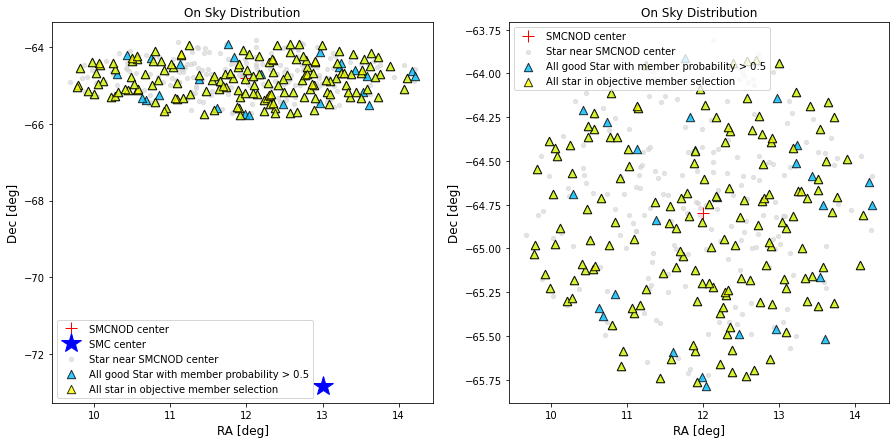

In [99]:
fig, ax = plt.subplots(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.plot(RA_smc, DEC_smc,'*b',ms=20,label="SMC center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='All good Star with member probability > 0.5')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, c='yellow', ec='k', zorder=3, alpha=0.8,
        label='All star in objective member selection')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.subplot(1,2,2)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='All good Star with member probability > 0.5')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, c='yellow', ec='k', zorder=3, alpha=0.8,
        label='All star in objective member selection')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

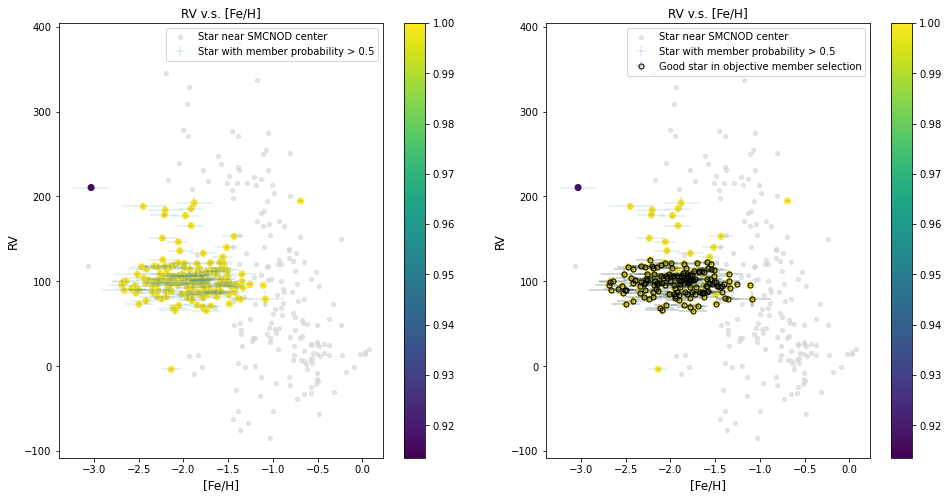

In [110]:
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(tab['feh50'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
#plt.errorbar(smcnod['feh50'], smcnod['vel_calib'], xerr=smcnod['feh_std'], yerr=smcnod['vel_calib_std'], fmt='o', mfc='none',ms=25, c='deepskyblue',label="All good Star star in member selection")
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')
plt.colorbar()
plt.legend()

plt.subplot(1,2,2)
plt.scatter(tab['feh50'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
plt.errorbar(tab_1['feh50'], tab_1['vel_calib'], xerr=tab_1['feh_std'], yerr=tab_1['vel_calib_std'], fmt='o', mfc='none',ms=5, c='k',lw=0.2,label="Good star in objective member selection")
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')
plt.colorbar()
plt.legend()

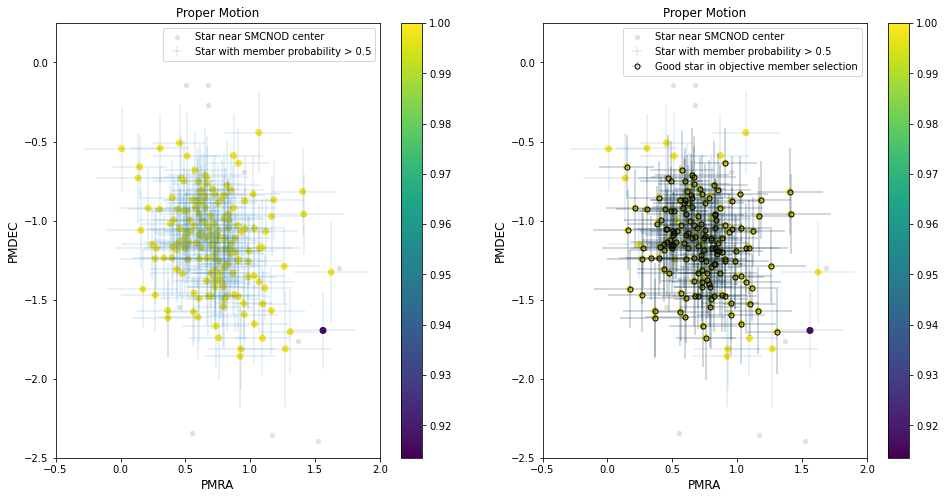

In [113]:
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(tab['pmra'],tab['pmdec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-2.5,0.25)
plt.colorbar()
plt.legend()

plt.subplot(1,2,2)
plt.scatter(tab['pmra'],tab['pmdec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
plt.errorbar(tab_1['pmra'], tab_1['pmdec'], xerr=tab_1['pmra_error'], yerr=tab_1['pmdec_error'], fmt='o', mfc='none',ms=5, c='k',lw=0.2,label="Good star in objective member selection")
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-2.5,0.25)
plt.colorbar()
plt.legend()

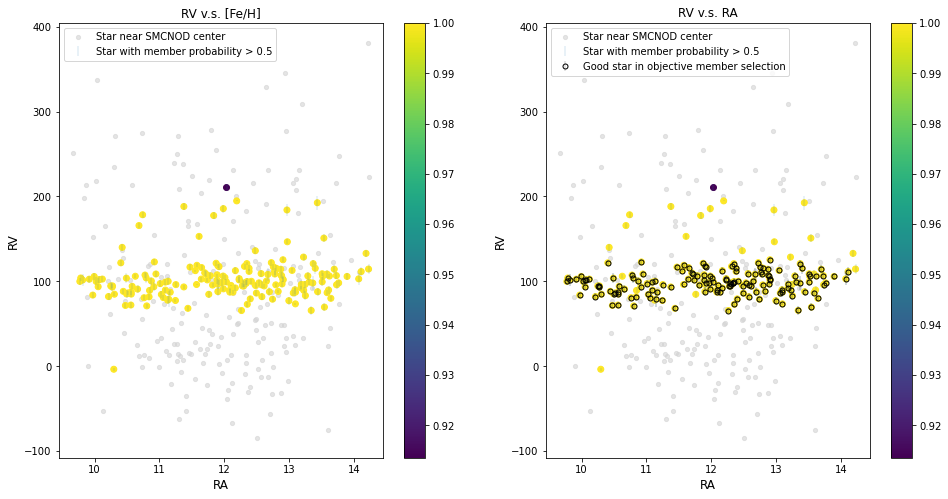

In [115]:
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(tab['ra'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['ra'], tab_good['vel_calib'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
#plt.errorbar(smcnod['ra'], smcnod['vel_calib'], xerr=smcnod['feh_std'], yerr=smcnod['vel_calib_std'], fmt='o', mfc='none',ms=25, c='deepskyblue',label="All good Star star in member selection")
plt.xlabel('RA', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')
plt.colorbar()
plt.legend()

plt.subplot(1,2,2)
plt.scatter(tab['ra'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['ra'], tab_good['vel_calib'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member probability > 0.5')
plt.errorbar(tab_1['ra'], tab_1['vel_calib'], yerr=tab_1['vel_calib_std'], fmt='o', mfc='none',ms=5, c='k',lw=0.2,label="Good star in objective member selection")
plt.xlabel('RA', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. RA')
plt.colorbar()
plt.legend()

In [36]:
# cut
g_band = tab['decam_g'] - 3.185 * tab['ebv']
r_band = tab['decam_r'] - 2.140 * tab['ebv']
i_band = tab['decam_i'] - 1.569 * tab['ebv']
g_cut = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_cut = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_cut = tab_good['decam_i'] - 1.569 * tab_good['ebv']
table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

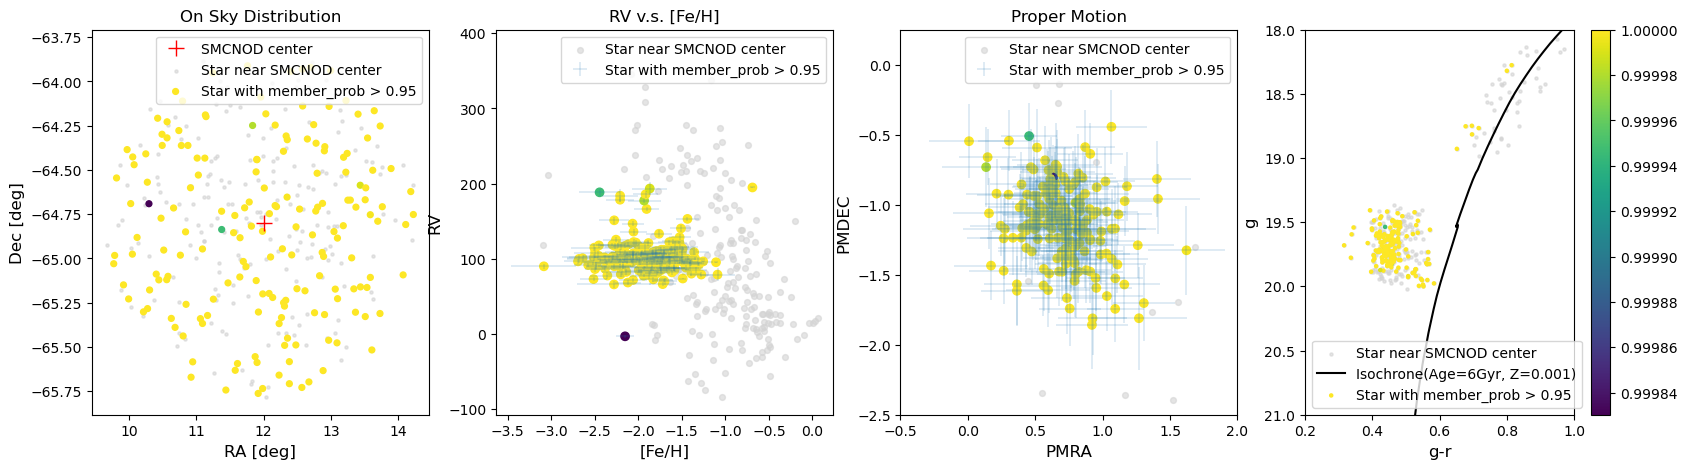

In [53]:
plt.figure(figsize=(20,5))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.95')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member_prob > 0.95')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')

plt.legend()
plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], fmt='None', marker='None',lw=0.2,label='Star with member_prob > 0.95')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-2.5,0.25)

plt.legend()
plt.subplot(1,4,4)
plt.scatter(g_band - r_band, g_band,marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(Age=6Gyr, Z=0.001)')
plt.scatter(g_cut - r_cut, g_cut, marker='.', s=20, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.95')
plt.xlim(0.2,1.0)
plt.ylim(18,21)
plt.xlabel('g-r', size = 12)
plt.ylabel('g', size = 12)
plt.gca().invert_yaxis()
plt.legend()
plt.colorbar()
plt.savefig('memberselect.png')
plt.show()